In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;

from nilearn.image import concat_imgs, mean_img
from nilearn import plotting
from nilearn.plotting import plot_stat_map, plot_design_matrix, plot_contrast_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn.reporting import get_clusters_table
from nilearn.glm import threshold_stats_img

from bids import BIDSLayout

In [2]:
# apply Gaussian kernel of 8mm (foecker was 5mm) and band-pass filtering
# run-specific intercept
# convolve with canonical HRF
# GLM predictor = target onset of different trial types
# additional regressors = error, post-error, timeout, and outlier trials

# combine both sessions as foecker2018 found no relevant differences acorss sessions.
# analyze all trials (correct and incorrect)
# foecker2018 also used SOA as regressor
# Emiliano used 90-ROIs from Shirer for resting state https://findlab.stanford.edu/functional_ROIs.html
# a more comperhensive atlas would be willard which contains 499 ROIs
# Emiliano used filtering of ([0.008 0.09]) 

# planned contrasts:
#   - invalid vs valid
#   - left vs right ( * valid vs invalid)
#   - interaction of cue vs target_position
#   - distractors????


In [29]:
# ACNets project folder (to access data and resources)
project_dir = Path('../..')

sns.set()
pd.set_option('display.max_rows', None)

# you need to download the preprocessed subject data before running the notebook:
# datalad get derivatives/fmriprep/sub-NVGP01* -r

In [16]:
layout = BIDSLayout(project_dir / 'data/julia2018',
                    derivatives=True,
                    database_path=project_dir / 'tmp/pybids_cache/julia2018')

task = 'attention'
sessions = ['1','2']
subjects = layout.get_subject()

# only one subject for now. Remove to process all subjects
sessions = ['1']
subjects = ['NVGP01']


confounds_cols = ['trans_x', 'trans_y', 'trans_z',
                  'rot_x', 'rot_y', 'rot_z',
                  'global_signal',
                  'a_comp_cor_00', 'a_comp_cor_01',
                  'cosine00', 'cosine01', 'cosine02']

TR = layout.get_tr(task=task,subject=subjects, session=sessions)


In [17]:
# %% load data for one subject (Note that subject and session are both in singluar)

anat_images = layout.get(subject=subjects,
                         datatype='anat',
                         space='MNI152NLin2009cAsym',
                         desc='preproc',
                         suffix='T1w',
                         scope='fmriprep',
                         extension='nii.gz',
                         return_type='filename')

func_images = layout.get(task=task,
                         desc='preproc',
                         subject=subjects,
                         session=sessions,
                         suffix='bold',
                         scope='fmriprep',
                         extension='nii.gz',
                         return_type='filename')

mask_images = layout.get(task=task,
                         desc='brain',
                         subject=subjects,
                         session=sessions,
                         suffix='mask',
                         scope='fmriprep',
                         extension='nii.gz',
                         return_type='filename')

events_files = layout.get(task=task,
                          subject=subjects,
                          session=sessions,
                          suffix='events',
                          scope='self',
                          extension='tsv',
                          return_type='filename')

confounds_files = layout.get(task=task,
                             subject=subjects,
                             session=sessions,
                             desc='confounds',
                             suffix='timeseries',
                             scope='fmriprep',
                             extension='tsv',
                             return_type='filename')

def fix_trial_type(df):
    df['trial_type'] = df['trial_type'] + '_' + df['event_type']
    return  df

events = [pd.read_table(ef).pipe(fix_trial_type) for ef in events_files]
# # TODO filter events

confounds = [pd.read_table(cf)[confounds_cols] for cf in confounds_files]



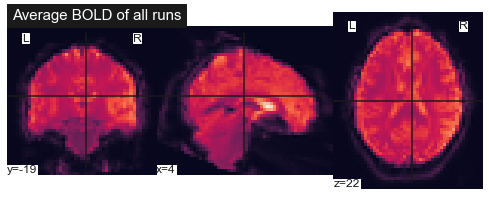

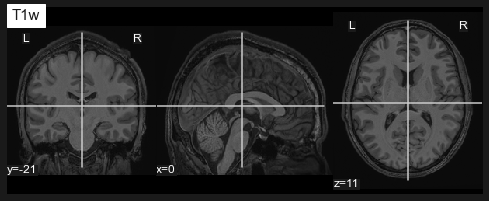

In [18]:
# all_fun_images = concat_imgs(fmri_images)
bg_image = mean_img(func_images)
plotting.plot_img(bg_image, title='Average BOLD of all runs')
plotting.plot_anat(anat_images[0], title='T1w')

plotting.show()


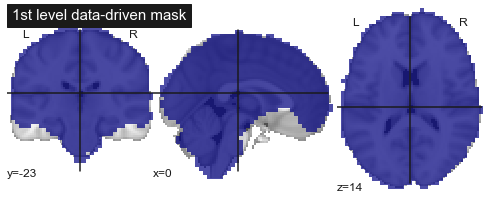

In [19]:
# fit GLM

# TODO which drift model to use
# TODO standardize and filtering
# TODO how to mask

fmri_glm = FirstLevelModel(t_r=TR,
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None, # instead using cosine confounds produced by fmriprep
                           high_pass=.01,
                           smoothing_fwhm=8,
                        #    mask_img=mni_mask_img,
                           subject_label=subjects)

fmri_glm = fmri_glm.fit(func_images, events=events, confounds=confounds)
design_matrices = fmri_glm.design_matrices_


plotting.plot_roi(fmri_glm.masker_.mask_img_, title='1st level data-driven mask')
plotting.show()

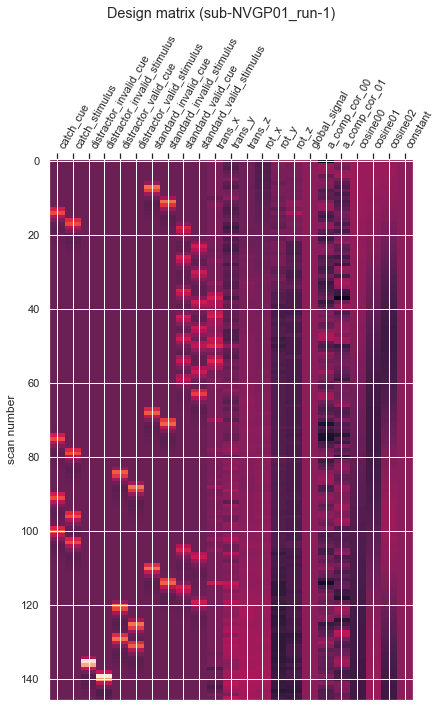

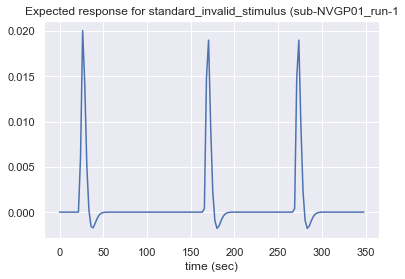

23
23
23
23
23
23
23
23


In [20]:
# plot design matrix (row=time, col=predictors)

plot_design_matrix(design_matrices[0])
plt.suptitle(f'Design matrix (sub-{subjects[0]}_run-1)')
plt.tight_layout()
plotting.show()

# plot expected HRF-convolved response
plt.plot(design_matrices[0]['standard_invalid_stimulus'])
plt.xlabel('time (sec)')
plt.title(f'Expected response for standard_invalid_stimulus (sub-{subjects[0]}_run-1')
plotting.show()

# DEBUG for d in design_matrices: print(len(d.columns))

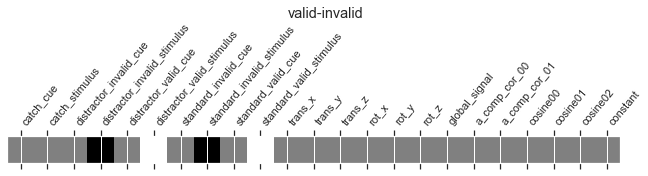

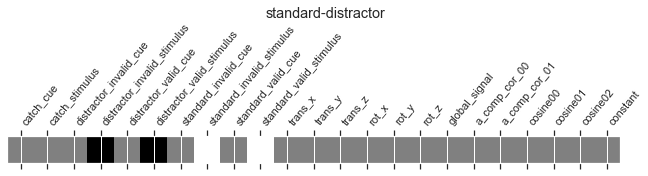

In [21]:
# define contrasts (structured way)


# canonical contrasts
_eyes = np.eye(design_matrices[1].shape[1]) # that +1 at the end makes up for multiple 'runs'
contrasts = {col: _eyes[i] for i, col in enumerate(design_matrices[1].columns)}

# contrasts = {}

# task-specific contrasts
contrasts['valid_stimulus'] = contrasts['standard_valid_stimulus'] + contrasts['distractor_valid_stimulus']
contrasts['invalid_stimulus'] = contrasts['standard_invalid_stimulus'] + contrasts['distractor_invalid_stimulus']
# contrasts['catch'] ='catch_stimulus'
# contrasts['invalid_cue'] = 'standard_invalid_cue + distractor_invalid_cue + catch_cue'
# contrasts['valid_cue'] = 'standard_invalid_cue + distractor_invalid_cue + catch_cue'
contrasts['distractor'] = contrasts['distractor_valid_stimulus'] + contrasts['distractor_invalid_stimulus']
contrasts['standard'] = contrasts['standard_valid_stimulus'] + contrasts['standard_invalid_stimulus']


# only keep relevant contrasts
contrasts = {
    'valid-invalid': contrasts['valid_stimulus'] - contrasts['invalid_stimulus'],
    'standard-distractor': contrasts['standard'] - contrasts['distractor'],
    # 'catch': contrasts['catch_stimulus']
}

# plot all the relevant contrasts
for key, val in contrasts.items():
    plot_contrast_matrix(val, design_matrix=design_matrices[0])
    plt.suptitle(key)

plotting.show()

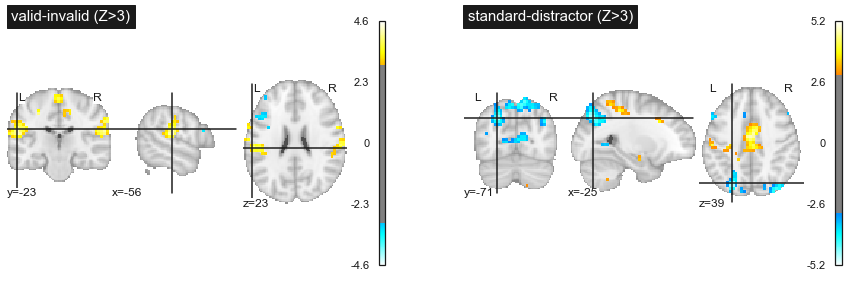

In [22]:
# effect size map, z map, and plot them
# eff_map = fmri_glm.compute_contrast(contrast, output_type='effect_size')

fig = plt.figure(figsize=(15, 5))

# compute and plot z-map for each contrast
for index, (contrast_name, contrast) in enumerate(contrasts.items()):
    ax = plt.subplot(1, len(contrasts), 1 + index)

    z_map = fmri_glm.compute_contrast(contrast, output_type='z_score')

    plot_stat_map(z_map, threshold=3.0, title=f'{contrast_name} (Z>3)', axes=ax) #, display_mode='z', cut_coords=3)

plotting.show()


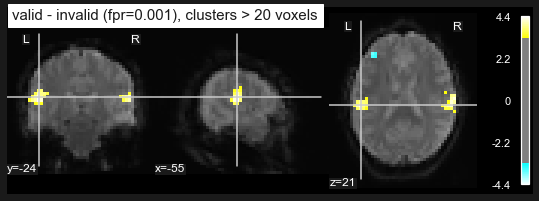

,X,Y,Z,Peak Stat,Cluster Size (mm3)
Cluster ID,,,,,
1,15.5,-64.5,-54.5,4.605831,896
2,-56.5,-24.5,17.5,4.359540,3648
2a,-52.5,-20.5,37.5,3.437931,
3,67.5,-16.5,21.5,4.214375,3200
3a,63.5,-24.5,21.5,4.177143,
3b,55.5,-12.5,17.5,3.772253,
3c,63.5,-32.5,17.5,3.651332,
4,-28.5,-24.5,45.5,4.020394,192
5,63.5,3.5,29.5,3.907425,448


In [37]:
# extract clusters info and coordinates

z_map = fmri_glm.compute_contrast(contrasts['valid-invalid'], output_type='z_score')

# TODO which cluster_threshold to use? read literature

corrected_map, threshold = threshold_stats_img(z_map,
                                               alpha=.001, height_control='fpr', # fdr, fpr, bonferroni
                                               cluster_threshold=20)

plot_stat_map(corrected_map, bg_img=bg_image, threshold=threshold,
              title='valid - invalid (fpr=0.001), clusters > 20 voxels')

plotting.show()

clusters_table = get_clusters_table(z_map, stat_threshold=threshold).set_index('Cluster ID')#.head(30)
clusters_table

In [42]:
from nilearn.reporting import make_glm_report

report = make_glm_report(model=fmri_glm, contrasts=contrasts['valid-invalid'])

In [43]:
report